# [NTDS'19] assignment 2: learning with graphs
[ntds'19]: https://github.com/mdeff/ntds_2019

[Clément Vignac](https://people.epfl.ch/clement.vignac), [EPFL LTS4](https://lts4.epfl.ch) and
[Guillermo Ortiz Jiménez](https://gortizji.github.io), [EPFL LTS4](https://lts4.epfl.ch).

## Students

* Team: `23`
* Students: `Zhou Xiao, Saibo Geng, Olavo Bacelar, Clarisse Poupon` (for the team submission)

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

In this assignment you will experiment with the main concepts of spectral graph theory, as well as familizarize yourself with the main data science techniques for network data.

The assignment is made of three parts:
1. [Spectral Graph Theory](#sgt)
1. [Regularization on graphs with Graph Signal Processing](#gsp)
1. [Machine Learning on Graphs](#ml)

<a id='sgt'></a>
## Part I: Spectral Graph Theory
### Eigenvectors and eigenvalues

We will start by reviewing some of the main concepts in spectral graph theory and see some of its applications to dimensionality reduction and data clustering. To illustrate the main concepts we will use the standard two moon dataset.

In [2]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

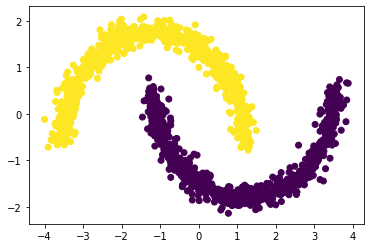

In [3]:
from pygsp.graphs import TwoMoons

G = TwoMoons(moontype='synthesized', N=2000)
X = G.coords
Y = G.labels.astype(int)

plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.show()

#### Question 1: Graph construction
Build a similarity graph using the euclidean distance between data points.   
**Note:** Use an RBF kernel to set the edge weights $w_{ij}=\exp(-||x_i- x_j||_2^2 / ~ 2 \sigma^2)$ of your adjacency and threshold the ones with the smallest magnitude.

In [7]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    pairwise_similarity_array = np.exp(-(pdist(X)**2) / (2*sigma**2))
    similarity_matrix = squareform(pairwise_similarity_array)
    adjacency = np.where(similarity_matrix >= epsilon, similarity_matrix, 0)
    return adjacency

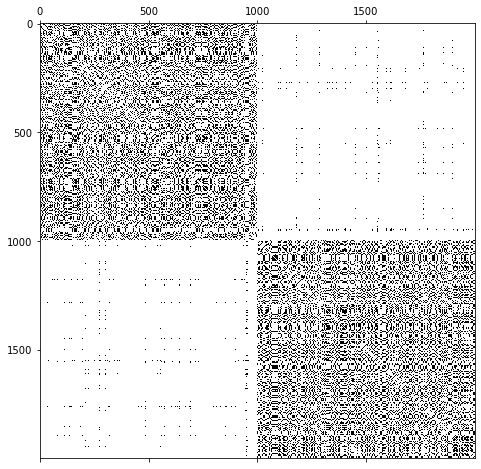

In [8]:
# Like this we could get a graph that almost has two components
adjacency = epsilon_similarity_graph(X, sigma=0.6, epsilon=1e-1)
#adjacency = epsilon_similarity_graph(X, sigma, epsilon)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.spy(adjacency)
plt.show()

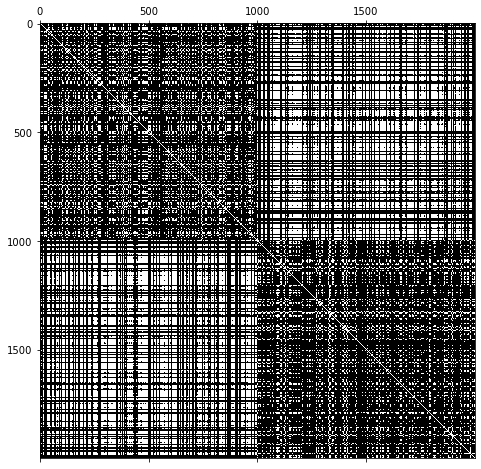

In [8]:
# In the end we chose this values for sigma and epsilon because in the future we want them to be more well connected
adjacency = epsilon_similarity_graph(X, sigma=0.6, epsilon=1e-8)
#adjacency = epsilon_similarity_graph(X, sigma, epsilon)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.spy(adjacency)
plt.show()

How do you choose `sigma`?

For the clustering in the question below, if we would have two components that were not or just barely connected, it would be too easy. The pair of values $\epsilon$ and $\sigma$ does not uniquely determine which set of points are going to be connected, but we set $\sigma$ to be a typical distance between two points of the same cluster that are kind of close but not so small that it would be out of reach for points from the other cluster. 


How do you choose the threshold `epsilon`?

We adjusted ε such that the resulting graph is connected so that the clustering question doesn't get too easy, but so there's not too many connections between clusters. After comparison, we think if we set epsilon to 1e-1, then it'll be easier to find clusters. Therefore, we set epsilon to 1e-8.

#### Question 2: Laplacian
Build the combinatorial and normalized graph laplacians for this dataset.

In [9]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    d = adjacency.shape[0]
    I = np.eye(d)
    D = np.diag(adjacency.sum(axis=0))
    D_half = np.diag(adjacency.sum(axis=0)**-0.5)

    if normalize:
        L = I - D_half@adjacency@D_half
    else:
        L = D - adjacency

    return L 

In [10]:
laplacian_comb = compute_laplacian(adjacency, normalize=False)
laplacian_norm = compute_laplacian(adjacency, normalize=True)

#### Question 3: Eigendecomposition

For both Laplacian matrices, compute the eigendecomposition $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues. Make sure that the eigenvalues are ordered, i.e., $\lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$. 

Justify your choice of a solver for the eigendecomposition.

In an undirected graph, the Laplacian is always real symmetric, so here we should use a specific solver for the eigen-decomposition of symmetric matrices, which saves computing time. However it doesn't give all the eigenvalues, so we use the normal solver.

In [11]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    lamb_unsorted, U_unsorted = np.linalg.eig(laplacian) 
    index = np.argsort(lamb_unsorted)
    lamb, U = lamb_unsorted[index], U_unsorted[:,index] 
    return lamb, U

In [12]:
lamb_comb, U_comb = spectral_decomposition(laplacian_comb)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

#### Question 4: Interpretation
We plot the sorted eigenvalues as a function of their index:

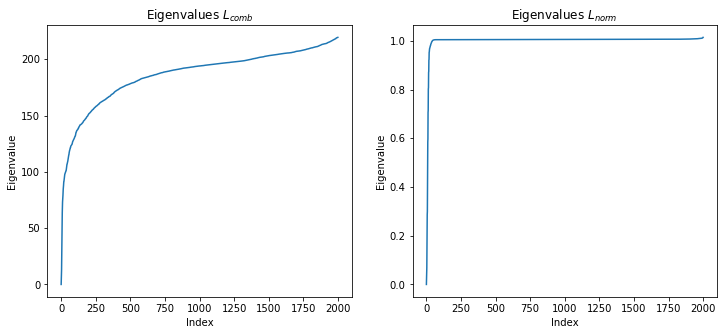

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(lamb_comb)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')
plt.subplot(122)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

What is the lowest eigenvalue $\lambda_0$ and the corresponding eigenvector $u_0$? Answer for both Laplacian matrices.

In [21]:
print(lamb_comb[0], lamb_norm[0])

9.325873406851315e-15 4.5102810375396984e-17


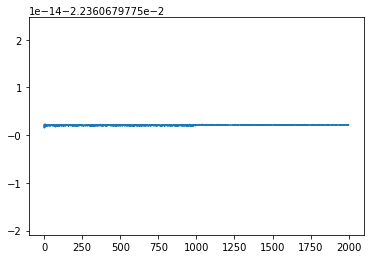

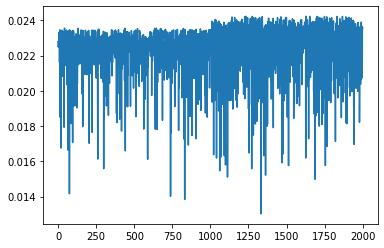

In [14]:
plt.plot(U_comb[:,0])
plt.show()
plt.plot(U_norm[:,0])

What is the lowest eigenvalue $\lambda_0$ and the corresponding eigenvector $u_0$? Answer for both Laplacian matrices.

The eigenvalues obtained are both very near zero, as was predicted by the theory. For the combinatorial Laplacian, its corresponding eigenvector is a constant vector of dimension 2000.
For the normalized Laplacian, its corresponding eigenvector $u_0$ can be interpreted as   $\frac{D^{1/2}1}{\|D^{1/2}\|}$.


When filtering a signal or computing polynomials, which Laplacian provides the best numerical stability? Justify your answer.

According to the plot, the normalized Laplacian has the better numerical stability because it can be observed that the eigenvalues are less sensitive to the change of the index and are near 1, and all the components of the normalized Laplacian matrix have absolute value equal or inferior to 1, which is good when you have factors of those.

#### Question 5: Connected components
The eigendecomposition provides an easy way to compute the number of connected components in the graph. Fill the following function:

In [15]:
def compute_number_connected_components(lamb: np.array, threshold: float):
    """ lamb: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    n_components = (lamb <= threshold).sum()
    return n_components

Tune the parameters $\epsilon$ and $\sigma$ of the similarity graph so that the graph is connected. Otherwise, clustering would be too simple!

In [16]:
#Test if our graph is connected.

def is_connected(A):
    s = A
    i = 2
    while  not (s>0).all():
        s += np.linalg.matrix_power(A,i)
        i += 1
        # only checks connectedness until i = 100 - assumes it's not connected if it ever gets there
        if i == 100:
            break
    return i-1 <= 100

is_connected(adjacency)  #

True

In [17]:
# We can check that the graph is connected because there is only one eigenvalue that is close to zero.

threshold = 0.0000000001
print(compute_number_connected_components(lamb_norm, threshold))

1


### Spectral clustering

Let us now see one application of spectral graph theory to clustering the two moon dataset.

#### Question 6: Baseline

As a baseline, let us first see how the simplest clustering algorithm, K-means, performs on this dataset. Use K-means to assign a cluster to each point.

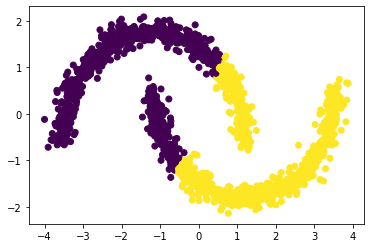

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
km_labels = kmeans.predict(X)
y_pred = km_labels  # Vector with cluster assignments
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

K-means cannot find a good solution to this problem. Why?

Beacuse the shape of clusters is not convex, and k-means clustering only performs well for convex clusters.

#### Question 7: Spectral clustering

As opposed to naive K-means, spectral clustering doesn't operate on the input space but on the eigenspace of the graph that represents the data. Implement spectral clustering. You can use 
[this tutorial](http://lasa.epfl.ch/teaching/lectures/ML_Phd/Notes/tutoSC.pdf).

In [19]:
class SpectralClustering():
    def __init__(self,adjacency, n_classes: int, normalize: bool):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = compute_laplacian(adjacency, self.normalize)
        self.e = spectral_decomposition(self.laplacian)[0][:self.n_classes]
        self.U = spectral_decomposition(self.laplacian)[1][:,:self.n_classes]
        self.clustering_method = KMeans(n_clusters=self.n_classes)
        
    def fit_predict(self, adjacency):

        if self.normalize:
            #normalize U by rows
            L2norm = np.sqrt((self.U**2).sum(axis=1))
            T = (self.U / L2norm.reshape(-1,1)).real
            #cluster the points with k-mean algorithm into clusters C_1,.....C_k
            self.clustering_method.fit(T)
            km_labels = self.clustering_method.predict(T)
            y_pred = km_labels
        if not self.normalize:
            #cluster the points with k-mean algorithm into clusters C_1,.....C_k
            self.clustering_method.fit(self.U)
            km_labels = self.clustering_method.predict(self.U)
            y_pred = km_labels
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        return y_pred

Connected components: 1


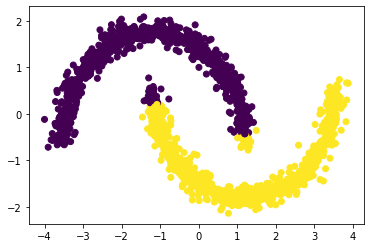

In [20]:
print("Connected components:", compute_number_connected_components(lamb_norm, threshold=1e-3))
spectral_clustering = SpectralClustering(adjacency,n_classes=2, normalize=True)
y_pred = spectral_clustering.fit_predict(adjacency)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

#### Question 8: On your dataset

Can you think of another 2D dataset in which k-means would badly perform, but spectral clustering would not?
Construct it!
For this question you can import any dataset of your choice, for example from `sklearn.datasets` or `pygsp.graphs`, but you can also get creative and define something of your own. First, create and plot the dataset.

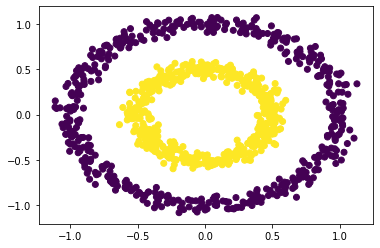

In [29]:
from sklearn.datasets import make_circles
#import datasets of double concentric cercles composed by 100 points.
X, y = make_circles(n_samples=1000,factor=0.5, random_state=0, noise=0.05)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

Run K-means:

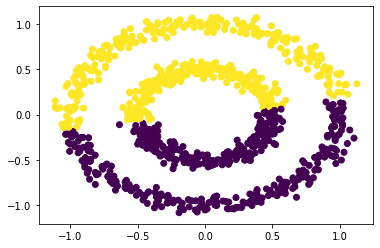

In [30]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
km_labels = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=km_labels)
plt.show() 

Create the similarity graph, and run spectral clustering with both the combinatorial and normalized Laplacian matrices:

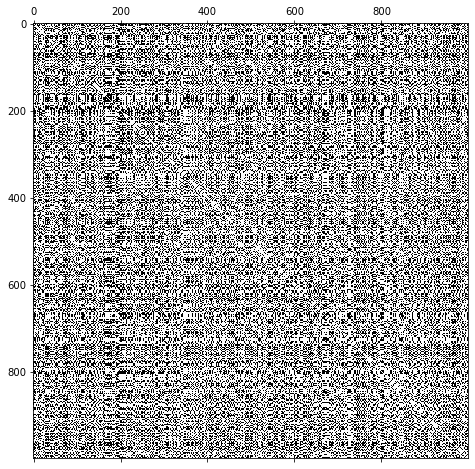

In [31]:
CercleAdj = epsilon_similarity_graph(X, sigma=1, epsilon=0.7)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.spy(CercleAdj)
plt.show()

Connected components: 1


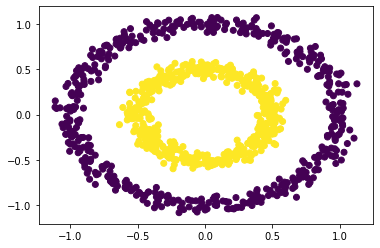

In [32]:
CercleLpcNorm = compute_laplacian(CercleAdj, normalize=True)
Cercle_lamb_norm, Cercle_U_norm = spectral_decomposition(CercleLpcNorm)

#number of connected components with threshold 
print("Connected components:", compute_number_connected_components(Cercle_lamb_norm, threshold=1e-3))
#use spectral clustering to classifer the digits data(1797 entries)
spectral_clustering = SpectralClustering(CercleAdj, n_classes=2, normalize=True)
y_pred = spectral_clustering.fit_predict(CercleAdj)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

With spectral clustering, we could detect well the two different classes, with the KMeans one we couldn't.

### Dimensionality Reduction with Laplacian Eigenmaps

Most datasets are very high-dimensional, which means it can be very hard to understand their geometry. Fortunately, there exists multiple  techniques that can help us to reduce the dimensionality of the data, and allow us to visualize it. 

In this part of the assignment we will use MNIST to compare these techniques. Indeed, without dimensionality reduction it would be very difficult to answer questions like: are the different digits clustered together in different areas of space? 

But first, let's load our dataset:

In [33]:
from utils import load_mnist

X_mnist, y_mnist = load_mnist()
classes = np.unique(y_mnist)

#### Question 9: Laplacian eigenmaps

Most dimensionality reduction algorithms are constructed such that some property of the dataset remains invariant in the lower dimensional representation. Before implementing laplacian eigenmaps, can you say what property of the data does this algorithm preserve?

*Your answer here*

Projects data to a lower dimension while preserving the geodesic distance (rather than Euclidean distance), which is the shortest distance between two points on a curve.

Implement a function that uses Laplacian eigenmaps to do dimensionality reduction.

In [34]:
def laplacian_eigenmaps(X: np.ndarray, dim: int, sigma: float, epsilon: float, normalize: bool):
    """ Return:
        coords (n x dim array): new coordinates for the data points."""
    adjacency = epsilon_similarity_graph(X, sigma, epsilon)
    laplacian = compute_laplacian(adjacency, normalize)
    if normalize:
        pass
    else:
        D_half = np.diag(adjacency.sum(axis=0)**-0.5)
        laplacian = D_half@laplacian@D_half
    lamb, U = spectral_decomposition(laplacian)
    #plt.plot(lamb[:100])
    index = np.where(lamb>1e-7)[0][:dim]
    print(index)
    coords = U[:, index]
    return coords

Use this function to visualize MNIST in 2D. Feel free to play with the different parameters.

[1 2]


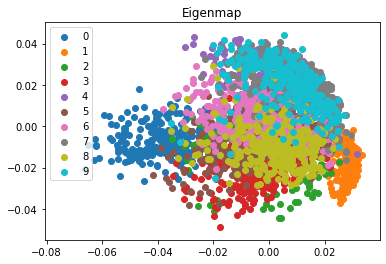

In [35]:
dim = 2
X_embedded = laplacian_eigenmaps(X_mnist,dim,sigma=1e4,epsilon=1e-2,normalize=True)
fig = plt.figure()
ax = fig.add_subplot(111)
for i in classes:
    mask = y_mnist == i
    plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=i)
plt.legend()
plt.title('Eigenmap')
plt.show()


Visualize MNIST in 3D:

[1 2 3]


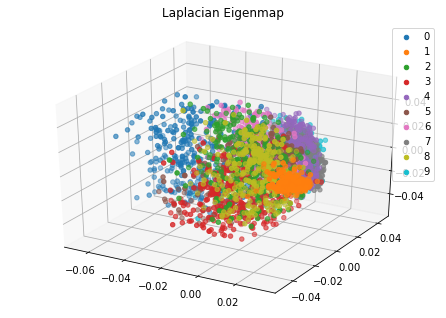

In [36]:
dim = 3
X_embedded=laplacian_eigenmaps(X_mnist,dim,sigma=1e4,epsilon=1e-2,normalize=True)
fig = plt.figure()
ax = Axes3D(fig)
for i in classes:
    mask = y_mnist == i
    ax.scatter(X_embedded[mask, 0], X_embedded[mask, 1], X_embedded[mask, 2], label=i)
ax.legend()
ax.title.set_text('Laplacian Eigenmap')
plt.show()

#### Question 10: Comparison with other methods  
We provide the visualization of MNIST with other methods:

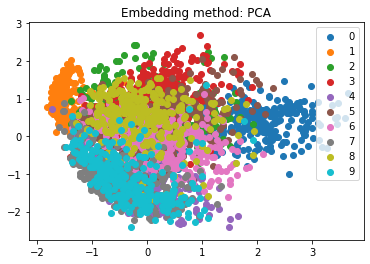

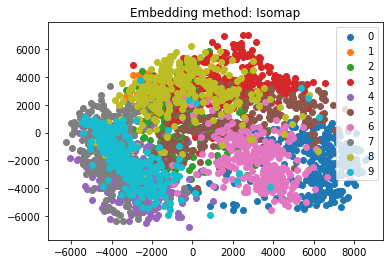

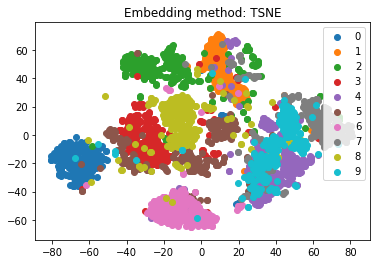

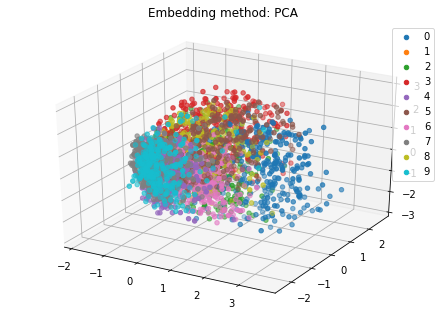

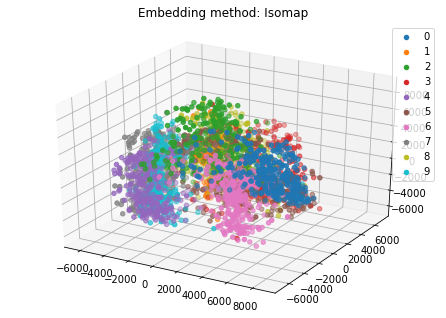

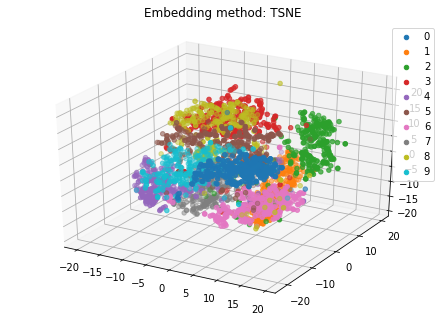

In [37]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

# This cell can take a few minutes to run
run_this_cell = True

if run_this_cell:
    # In 2d
    embeddings = [PCA(n_components=2, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=2, n_neighbors=5),
                  TSNE(n_components=2)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(X_mnist)
        fig = plt.figure()
        for i in classes:
            mask = y_mnist == i
            plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=i)
        plt.legend()
        plt.title('Embedding method: '+ type(embedding).__name__)
        plt.show()

    # In 3d
    embeddings = [PCA(n_components=3, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=3, n_neighbors=5),
                  TSNE(n_components=3)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(X_mnist)
        fig = plt.figure()
        ax = Axes3D(fig)
        for i in classes:
            mask = y_mnist == i
            ax.scatter(X_embedded[mask, 0], X_embedded[mask, 1], X_embedded[mask, 2], label=i)
        ax.legend()
        ax.title.set_text('Embedding method: '+ type(embedding).__name__)
        plt.show()

In a few words, what are the principles guiding the design of each method? Compare their results.

*Your answer here*

PCA maximizes the variance after projecting the data points on lower dimensions. Isomap aims to find low dimensional reconstruction with geodesic distances. In T-SNE, similiar objects are modelling by nearby points and dissimilar objects are modeled by distant points by probability distribution. According to our results, visually the cluster cannot be separated clearly while Isomap have a visually better result according to 3D clustering plot. In comparison, T-SNE realize a clear cluster separation even in a 2D plot. Therefore, T-SNE shows a best ability to solve the problem in the case.

<a id='gsp'></a>
## Part II: Regularization on graphs with Graph Signal Processing

In this part of the assignment we are going to familiarize ourselves with the main concepts in Graph Signal Processing and regularization on graphs in general. From now on, you can only use the following libraries as well as the functions that you implemented in the previous parts.

In [38]:
import pandas as pd
import numpy as np
from pygsp.graphs import Bunny

In this exercise we will use a nearest-neighbor graph constructed from the Stanford Bunny point cloud included in the PyGSP library.

In [39]:
G = Bunny()
adjacency = np.asarray(G.W.todense())
n_nodes = adjacency.shape[0]

We will use the following function to plot our signals on this graph.

In [40]:
def plot_bunny(x=None, title='', vlim=[-0.03, 0.03]):
    fig = plt.gcf()
    ax = plt.gca()
    if not isinstance(ax, Axes3D):
        ax = plt.subplot(111, projection='3d')
    if x is not None:
        x = np.squeeze(x)

    p = ax.scatter(G.coords[:,0], G.coords[:,1], G.coords[:,2], c=x, marker='o',
                   s=5, cmap='RdBu_r', vmin=vlim[0], vmax=vlim[1])
    ax.view_init(elev=-90, azim=90)
    ax.dist = 7
    ax.set_axis_off()
    ax.set_title(title)
    if x is not None:
        fig.colorbar(p)

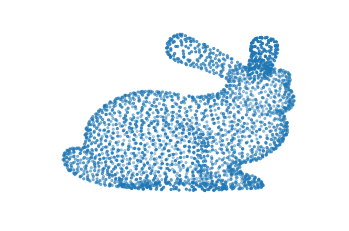

In [41]:
plt.subplot(111, projection='3d')
plot_bunny()

#### Question 11: Graph frequencies

Let us start by constructing the normalized graph laplacians from the adjacency matrix and find its spectral decomposition.

In [42]:
laplacian = compute_laplacian(adjacency, normalize=True)
lam, U = spectral_decomposition(laplacian)

Plot the eigenvalues.

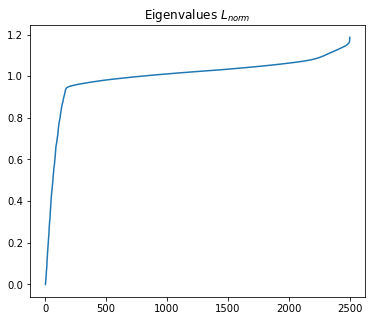

In [43]:
plt.figure(figsize=(6, 5))
plt.plot(lam)
plt.title('Eigenvalues $L_{norm}$')
plt.show()

To make things more clear we will plot some of its eigenvectors (0, 1, 3, 10, 100) as signals on the bunny graph.

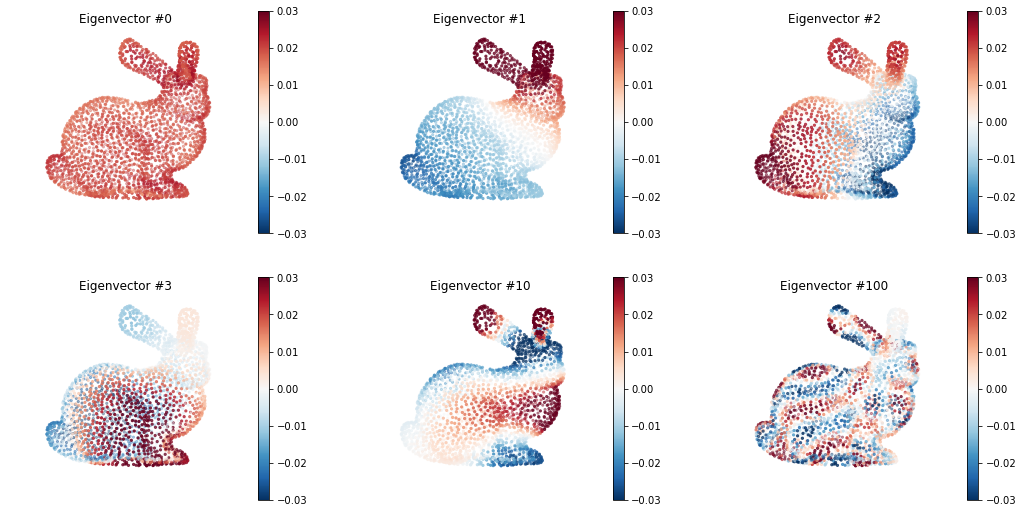

In [44]:
plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=U[:,0], title='Eigenvector #0')
plt.subplot(232, projection='3d')
plot_bunny(x=U[:,1], title='Eigenvector #1')
plt.subplot(233, projection='3d')
plot_bunny(x=U[:,2], title='Eigenvector #2')

plt.subplot(234, projection='3d')
plot_bunny(x=U[:,3], title='Eigenvector #3')
plt.subplot(235, projection='3d')
plot_bunny(x=U[:,10], title='Eigenvector #10')
plt.subplot(236, projection='3d')
plot_bunny(x=U[:,100], title='Eigenvector #100')

What can you say in terms of the variation (smoothness) of these signals? How can the smoothness of a signal be measured?

*Your answer here*


The smoothness of these signals is decreasing. The first graph is very smooth since the color is very uniform (quasi constant), but the last one is very variant.
The smoothness of a signal can be measured by the variation of the graph color / values of the eigenvector, which is specified by the value of the Laplacian quadratic form. The bigger is the variation, the bigger is the value of the quadratic form of the Laplacian, and the less smooth is the signal

#### Question 12: Graph Fourier Transform

Create a function to compute the Graph Fourier Transform (GFT) of a graph signal and its inverse.
**Note**: You can assume that you have internal access to the eigendecomposition (`U` and `lam`) of the laplacian.

In [45]:
def GFT(signal: np.ndarray):
    return U.T @ signal

def iGFT(fourier_coefficients: np.ndarray):
    return U @ fourier_coefficients

Now, let's create a graph signal:

C:\Users\Focus\.conda\envs\ntds\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


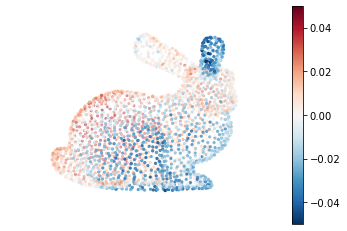

In [46]:
x = G.coords[:, 0] + G.coords[:, 1] + 3 * G.coords[:, 2]
x /= np.linalg.norm(x) 

noise = np.random.randn(n_nodes)
noise /= np.linalg.norm(noise) 

x_noisy = x + 0.3*noise

plot_bunny(x_noisy, vlim=[min(x_noisy), max(x_noisy)]);

and plot its graph spectrum:

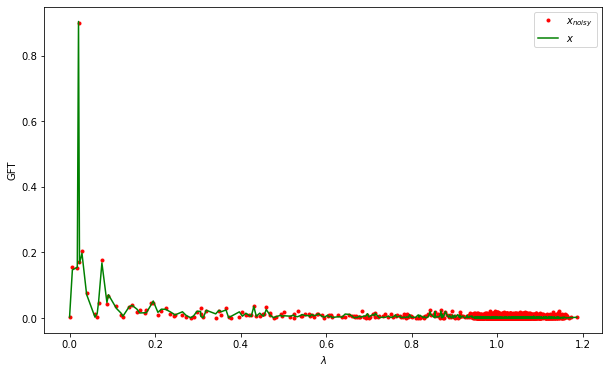

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(lam, np.abs(GFT(x_noisy)), 'r.') 
plt.plot(lam, np.abs(GFT(x)), 'g-')
plt.xlabel('$\lambda$')
plt.ylabel('GFT')
plt.legend(['$x_{noisy}$', '$x$'])

#### Question 13: Graph filters

We will try to extract the signal from the noise using graph filters. Let us start by creating three ideal graph filters.

In [48]:
ideal_lp = np.ones((n_nodes,))
ideal_bp = np.ones((n_nodes,))
ideal_hp = np.ones((n_nodes,))

ideal_lp[lam >= 0.1] = 0  # Low-pass filter with cut-off at lambda=0.1
ideal_bp[lam < 0.1] = 0  # Band-pass filter with cut-offs at lambda=0.1 and lambda=0.5
ideal_bp[lam > 0.5] = 0
ideal_hp[lam <= 1] = 0  # High-pass filter with cut-off at lambda=1

Additionally, create the ideal graph filter that implements the solution of Tikhonov regularization.

In [49]:
alpha = 0.99 / np.max(lam)

ideal_tk =  1/(1+alpha*lam)

Let's plot the spectral responses:

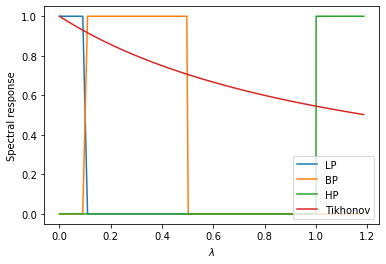

In [50]:
plt.plot(lam, ideal_lp, '-', label='LP')
plt.plot(lam, ideal_bp, '-', label='BP')
plt.plot(lam, ideal_hp, '-', label='HP')
plt.plot(lam, ideal_tk, '-', label='Tikhonov')
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(loc='lower right')
plt.show()

Create a function to filter a signal given an ideal graph filter

In [51]:
def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
    """Return a filtered signal."""
    return U@np.diag(spectral_response)@U.T@x

Let us visualize the results:

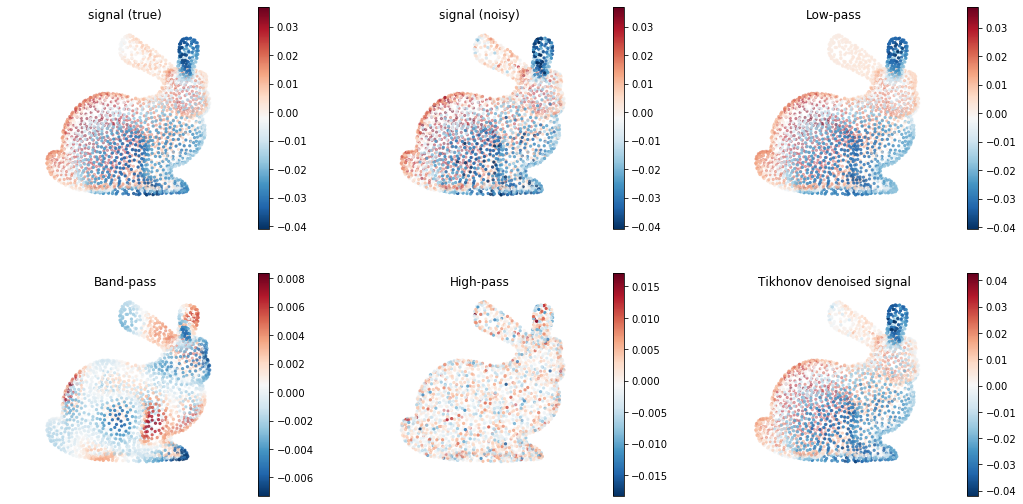

In [52]:
x_lp = ideal_graph_filter(x_noisy,ideal_lp)
x_bp = ideal_graph_filter(x_noisy,ideal_bp)
x_hp = ideal_graph_filter(x_noisy,ideal_hp)
x_tk = ideal_graph_filter(x_noisy,ideal_tk)

plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=x, title='signal (true)', vlim=[min(x), max(x)])
plt.subplot(232, projection='3d')
plot_bunny(x=x_noisy, title='signal (noisy)', vlim=[min(x), max(x)])
plt.subplot(233, projection='3d')
plot_bunny(x=x_lp, title='Low-pass', vlim=[min(x_lp), max(x_lp)])
plt.subplot(234, projection='3d')
plot_bunny(x=x_bp, title='Band-pass', vlim=[min(x_bp), max(x_bp)])
plt.subplot(235, projection='3d')
plot_bunny(x=x_hp, title='High-pass', vlim=[min(x_hp), max(x_hp)])
plt.subplot(236, projection='3d')
plot_bunny(x=x_tk, title='Tikhonov denoised signal', vlim=[min(x_tk), max(x_tk)])

How would you link to the observations you made before about the spectral decomposition of the laplacian?
Also, judging from the results, what type of model prior do you think Tikhonov regularization enforces?

The signal to which we added noise was a mixture of signals, which were eigenvectors with low eigenvalues. Therefore the low-pass was much better than the band-pass and the high-pass at reducing the noise. The Tikhonov regularization enforced a prior on the eigenvalues that decreases smoothly, which is equivalent to a smoothness prior on the signal - it eliminates too much variation. It  was also quite effective at getting rid of the noise, since it also gives more weight to the eigenvectors with a smaller eigenvalue, i.e. with less variation. 

#### Question 14: Polynomial graph filters

We have seen how we can use the GFT to define different filters that enhance or reduce certain frequency bands. However, to do so, we require an explicit eigendecomposition of the graph laplacian, which has a cost $O(n^3)$. For very large graphs this is very intense computationally. We will now see how we can obtain similar results by filtering the signals directly without resorting to an eigendecomposition.

The key idea is to use a polynomial of the graph laplacian to define a graph filter, i.e., $g(L)x=\sum_{k=1}^K \alpha_k L^k x$, and use the fact that the powers of a diagonalizable matrix can be written in terms of powers of its eigenvalues. This is
$$
L^k=(U\Lambda U^T)^k=U\Lambda^k U^T = U\begin{bmatrix}
(\lambda_0)^k &\dots & 0\\
\vdots & \ddots & \vdots\\
0 & \dots & (\lambda_N)^k
\end{bmatrix} U^T.
$$

This means that a polynomial of the graph laplacian acts independently on each eigenvalue of the graph, and has a frequency spectrum of
$$g(\lambda)=\sum_{k=1}^K \alpha_k \lambda^k.$$
Hence,
$$g(L)x=\sum_{k=1}^K \alpha_k L^k x=\sum_{k=1}^K \alpha_k U\Lambda^k U^T x=U \left(\sum_{k=1}^K \alpha_k\Lambda^k \right)U^T x=\operatorname{iGFT}\left(g(\Lambda)\operatorname{GFT}(x)\right).$$

With these ingredients, we have reduced the design of graph filters in the vertex domain to a regression task that approximates a given spectral response by a polynomial. There are multiple ways to do this, but in this assignment we will implement a very simple strategy based on [least-squares regression](https://en.wikipedia.org/wiki/Polynomial_regression#Matrix_form_and_calculation_of_estimates).

Implement a function to find the coefficients of a polynomial that approximates a given ideal filter.
**Hint:** `np.vander` and `np.linalg.lstsq`.

In [53]:
# np.vander generates a vandermund matrix from vector lam, then use np.linalg.lstsq to
# find the best solution by performing least square equations

def fit_polynomial(lam: np.ndarray, order: int, spectral_response: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    spectral_features = np.vander(lam, order, increasing=True)
    coeffs = np.linalg.lstsq(spectral_features, spectral_response)[0]
    return coeffs

Implement a function to compute the frequency response of that filter.

In [54]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    spectral_features = np.vander(lam, len(coeff), increasing=True)
    response = spectral_features @ coeff
    return response

Let us fit the Tikhonov ideal filter with several polynomials of different order.

C:\Users\Focus\.conda\envs\ntds\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


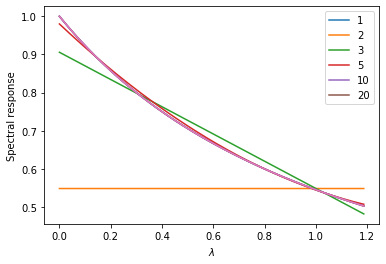

In [61]:
plt.plot(lam, ideal_tk)
orders = [1, 2, 3, 5, 10, 20]
for order in orders:    
    coeff_tk = fit_polynomial(lam, order, ideal_tk)
    plt.plot(lam, polynomial_graph_filter_response(coeff_tk, lam))

plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(orders)
plt.show();

So far, we have only defined a way to compute the coefficients of our laplacian polynomial. Let us now compute our graph filter.

In [62]:
def polynomial_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    ideal_tk_poly=polynomial_graph_filter_response(coeff, lam)
    x_tk_polynomial = ideal_graph_filter(x_noisy,ideal_tk_poly)
    return x_tk_polynomial

Based on the previous plot, choose a filter order that achieves (in your opinion) a good tradeoff in terms of computational complexity and response accuracy.

In [63]:
order =  5
#From the previous plot, we can observe that from order=5, the polynomial begins to 
#produces curves quite close to the ideal one. Thus, in order to have a good tradeoff, order =5 should be fine.
coeff_tk = fit_polynomial(lam, order, ideal_tk)

C:\Users\Focus\.conda\envs\ntds\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


#### Question 15: ARMA filter

As you have seen in class, polynomial graph filters are only one of the ways in which you can approximate ideal graph filters. 
In this sense, ARMA filters are a natural way to implement Tikhonov denoising on graphs.
Let us recall the general solution of the Tikhonov regularized denoising problem 

$$y=(I+\alpha L)^{-1}x. $$

With a little bit of algebra manipulation we can rewrite this expression as
$$
    y = -\alpha L y + x,
$$
from which we can derive the iterative algorithm
$$
    y_k = -\alpha L y_{k-1} + x\qquad k=1,2,\dots
$$
which is guaranteed to converge as long as $\alpha \lambda_{max} < 1$.

Implement the ARMA version of Tikhonov regularization.

In [64]:
def arma_tikhonov(x: np.ndarray, laplacian: np.ndarray, alpha: float, max_iter=50):
    """ Return an array of the same shape as x."""
    d = x.shape[0]
    y = np.dot(np.linalg.inv((np.eye(d)+alpha*laplacian)),x)
    for i in range(max_iter-1):
        y = -alpha*np.dot(laplacian,y) + x
    return y

Filter the previous noisy graph signal with the polynomial and ARMA approximations of the ideal Tikhonov filter.

In [65]:
x_tk_polynomial =  polynomial_graph_filter(coeff_tk, laplacian)
x_tk_arma = arma_tikhonov(x_noisy, laplacian, alpha)

Let us compare with the previous version.

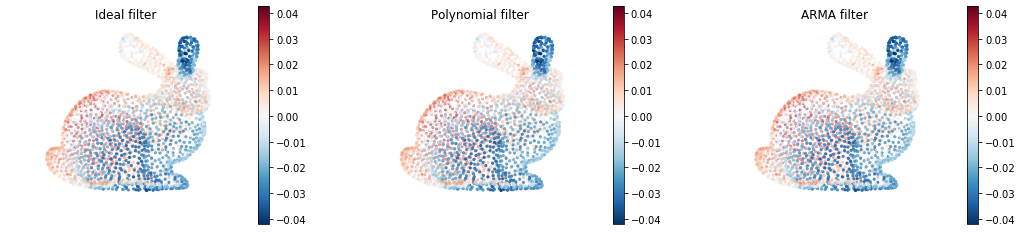

In [66]:
plt.figure(figsize=(18, 4))
plt.subplot(131, projection='3d')
plot_bunny(x_tk, title='Ideal filter', vlim=[min(x_tk), max(x_tk)])
plt.subplot(132, projection='3d')
plot_bunny(x_tk_polynomial, title='Polynomial filter', vlim=[min(x_tk), max(x_tk)])
plt.subplot(133, projection='3d')
plot_bunny(x_tk_arma, title='ARMA filter', vlim=[min(x_tk), max(x_tk)])

<a id='ml'></a>
## Part III: Machine Learning on Graphs

So far, we have only played with toy examples. Let us see the use of these tools in practice! In particular, let us see how we can use some graph filters to construct features to feed a classifier. For this part of the assignment we will import some extra packages.

In [73]:
import time

import networkx as nx
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.function as fn
from dgl import DGLGraph
from dgl.data.citation_graph import load_cora

np.random.seed(0)
torch.manual_seed(1)

We will use the CORA dataset and the citation graph that we created in Assignment 1. However, to simplify the next tasks we will directly use the preprocessed version of this dataset contained within the Deep Graph Library (DGL).

In this assignment, we will interpret CORA's features as multidimensional graph signals living on the citation graph.
Our task is to design a classifier that uses these features and the geometry of the graph can identify the type of paper each node represents.

The goal of this exercise is to do semi-supervised learning on graphs.
We assume that we know to which scientific field a small subset of the papers belongs (the ones contained in `train_mask`).
The goal is to predict to which field the other papers belong, using both the citation graph and the bag-of-word representation of each paper.

In [74]:
cora = load_cora()

features = torch.FloatTensor(cora.features)    # Feature vector for each paper
labels = torch.LongTensor(cora.labels)         # The field to which each paper belongs

train_mask = torch.BoolTensor(cora.train_mask) # Mask of nodes selected for training
val_mask = torch.BoolTensor(cora.val_mask)     # Mask of nodes selected for validation
test_mask = torch.BoolTensor(cora.test_mask)   # Mask of nodes selected for testing

in_feats = features.shape[1]
n_classes = cora.num_labels
n_edges = cora.graph.number_of_edges()

graph = cora.graph
adjacency = np.asarray(nx.to_numpy_matrix(graph))
n_nodes = adjacency.shape[0]

For this exercise we will use the normalized laplacian.

In [75]:
laplacian = compute_laplacian(adjacency, normalize=True)
lam, U = spectral_decomposition(laplacian)
lam_max = np.max(lam)

#### Question 16: Logistic regression

The simplest classification method consists in ignoring the citation graph and trying to classify the papers using only the features.
In this case, the problem is viewed as a standard classification task.
To train our classifier we will select a few nodes in our graph for training and fit a [logistic regression classifier](https://en.wikipedia.org/wiki/Logistic_regression) on them.
To avoid overfitting to the test set when we do hyperparameter tuning, we will also select a validation set.
And finally, we will test our classifier on the rest of the nodes.
**Hint:** use `sklearn.linear_model.LogisticRegression`.

In [76]:
train_features = features[train_mask]
train_labels = labels[train_mask]
val_features = features[val_mask]
val_labels = labels[val_mask]
test_features = features[test_mask]
test_labels = labels[test_mask]

In [77]:
# Fit a logistic regression model
# Didn't use regularization here
from sklearn.linear_model import LogisticRegressionCV  #
clf = LogisticRegressionCV(solver='lbfgs', random_state=0, multi_class='multinomial', max_iter=1000).fit(train_features, train_labels)

C:\Users\Focus\.conda\envs\ntds\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [78]:
train_acc = clf.score(train_features, train_labels)
val_acc = clf.score(val_features, val_labels)
test_acc = clf.score(test_features, test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 1.0000 | Validation accuracy 0.5733 | Test accuracy 0.5760


#### Question 17: Handcrafted graph filters

That's not a bad start! Now, let's try to improve a bit the results by taking into account the graph structure using tools from GSP. For this purpose, we will design a handcrafted filter that will be used to denoise the signal, before feeding it to a logistic regression.

However, before we start, what hypothesis can you make on the spectral properties of the denoised signal?

*Your answer here* We can guess that most of the signal can be explained with the eigenvectors corresponding to the low eigenvalues for example -- therefore we choose a low-pas filter.

Based on this prior, design an ideal filter response that you believe could enhance important features of the graph. 

**Note:** you just need to design one graph filter that we will apply to all features. Don't design a different filter for each feature. 

**Note:** finding the right filter can be very challenging, don't worry if you can't find it. Just make sure you experiment with a few configurations and parameters.

In [79]:
ideal_lp = np.ones((n_nodes,))
ideal_bp = np.ones((n_nodes,))
ideal_hp = np.ones((n_nodes,))

ideal_lp[lam >= 0.1] = 0  # Low-pass filter with cut-off at lambda=0.1
ideal_bp[lam < 0.1] = 0  # Band-pass filter with cut-offs at lambda=0.1 and lambda=0.5
ideal_bp[lam > 0.5] = 0
ideal_hp[lam <= 1] = 0  # High-pass filter with cut-off at lambda=1

ideal_filter = ideal_lp

Choose a filter order to approximate your filter using laplacian polynomials.

In [80]:
order =  8

def ideal_graph_filter_(x: np.ndarray, spectral_response: np.ndarray):
    return U@np.diag(spectral_response)@U.T@x.numpy()

def polynomial_graph_filter_(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    ideal_tk_poly = polynomial_graph_filter_response(coeff, lam)
    x_tk_polynomial = ideal_graph_filter_(features,ideal_tk_poly)
    
    return x_tk_polynomial

def polynomial_graph_filter_response_(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    spectral_features = np.vander(lam, len(coeff), increasing=True)
    frequency_response = spectral_features@coeff
    return frequency_response

coeff = fit_polynomial(lam, order, ideal_filter);
graph_filter = polynomial_graph_filter_(coeff, laplacian);

C:\Users\Focus\.conda\envs\ntds\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


Let's plot the frequency response of your spectral template and its polynomial approximation.

C:\Users\Focus\.conda\envs\ntds\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


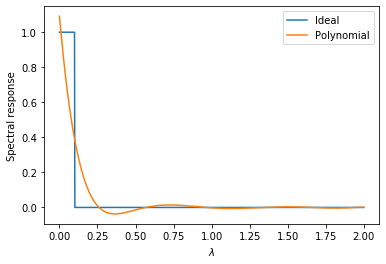

In [81]:
plt.plot(lam, ideal_filter)
plt.plot(lam, polynomial_graph_filter_response_(coeff, lam))
plt.legend(['Ideal', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.show();

Now, let's create the new features.

In [82]:
filtered_features = graph_filter.real

train_features = filtered_features[train_mask,:]
train_labels = labels[train_mask]

val_features = filtered_features[val_mask,:]
val_labels = labels[val_mask]

test_features = filtered_features[test_mask,:]
test_labels = labels[test_mask]

Train another logistic regression classifier on the new features. Remember to play with the regularization parameters to achieve a well performing model.

In [83]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegressionCV  #
Cs_range = np.logspace(1,4,50)
train_features = train_features.real

clf = LogisticRegressionCV(cv=5, random_state=0,multi_class='multinomial', max_iter=1000).fit(train_features, train_labels)

C_best = clf.C_[0]
print(C_best)

1291.5496650148827


Evaluate your model.

In [84]:
val_features = val_features.real
test_features = test_features.real
train_acc = clf.score(train_features,train_labels)
val_acc = clf.score(val_features,val_labels)
test_acc = clf.score(test_features,test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 0.8643 | Validation accuracy 0.8433 | Test accuracy 0.8240


#### Question 18: Graph convolutional networks

By now, you will probably have seen that it is challenging to find the right combination of spectral response, filter parameters and regularization method. And in most cases, this is a painstaking job. Wouldn't it be great to automate these tasks?

Fortunately, this is possible if we use the right tools! Specifically, we will see that Graph Convolutional Networks are a great framework to automatize the feature extraction method.

In this exercise, we will follow the same classification pipeline as above, but instead of hand-crafting our filter we will let `PyTorch` find the coefficients for us using gradient descent.

In this section, most of the code is already written. Try to understand it and to play with some parameters. It may be useful if you want to solve some learning task in your project.

We start by constructing a `LaplacianPolynomial` model in `DGL`. It computes the function: $f(X) = \sum_{i=1}^{k} \alpha_i L^i X \theta$ where the trainable parameters are the coefficients $\alpha_i$ and the matrix $\theta$. This function can be interpreted as a filtering of $X$ by $\sum_{i=1}^{k} \alpha_i L^i$ followed by a linear layer.

In [85]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k + 1):
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

Once we have are model ready we just need to create a function that performs one step of our training loop, and another one that evaluates our model.

In [86]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

Choose the training parameters.

We changed those a bit to try to get a better test accuracy

In [90]:
pol_order = 6
lr = 0.2
weight_decay = 5e-6
n_epochs = 1000
p_dropout = 0.8
momentum = 0.1

And train the classifier end to end.

In [94]:
from IPython.display import clear_output

graph = DGLGraph(cora.graph)

model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features, labels, val_mask)
    clear_output(wait=True)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.3f} | Val Accuracy {:.3f}". format(
            epoch, np.mean(dur), loss.item(), acc))
    
    
acc = evaluate(model, graph, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

Epoch 00999 | Time(s) 0.0419 | Train Loss 0.068 | Val Accuracy 0.783
Test Accuracy 0.7700


Trained this way our GCN based on polynomials of the laplacian is a black box. Fortunately, however, the only difference between this shallow model and our previous classifier is the way we chose the filter coefficients.

Let's see what the network learned.
Print the coefficients of the learned filter.

In [95]:
coeff_gcn = model.pol_weights.data
print(coeff_gcn)

tensor([-16.7098,  17.4648,   2.0881,  -2.2902,  -2.5060,  -1.1566,   0.8715])


To interpret the model we can plot the frequency response of the learned filter.

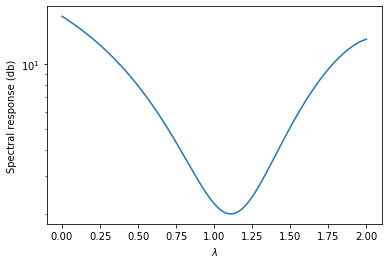

In [96]:
plt.semilogy(lam.real, np.abs(polynomial_graph_filter_response_(coeff_gcn.numpy(), lam)));
plt.xlabel('$\lambda$');
plt.ylabel('Spectral response (db)')
plt.show();

#### Question 19

As we said, the whole classification pipeline of the previous exercise is identical to the one we tried before: Graph filtering + Logistic regression. The only difference lies in the way we chose the filter coefficients. First we were choosing them manually, and now, we let `PyTorch` find them for us. However, if everything is correct we should be able to use this filter to construct new hand-crafted features and train a logistic regression model that achieves good accuracy on the training set. Let's do that!

Use the learned coefficients to train a new feature extractor:

In [97]:
graph_gcn_filter =  np.abs(polynomial_graph_filter_response_(coeff_gcn.numpy(), lam))

Let's extract the new features by filtering the data:

In [98]:
features_gcn = ideal_graph_filter_(features,graph_gcn_filter)
#features_gcn = graph_gcn_filter @ features.numpy()
features_gcn=features_gcn.real
train_features_gcn = features_gcn[train_mask,:]
train_labels = labels[train_mask]
val_features_gcn = features_gcn[val_mask,:]
val_labels = labels[val_mask]
test_features_gcn = features_gcn[test_mask,:]
test_labels = labels[test_mask]

Train a logistic regression on these features:

In [99]:
clf = LogisticRegressionCV(cv=5, random_state=0,multi_class='multinomial', max_iter=1000).fit(train_features.real, train_labels)

Finally, let's evaluate this model:

In [100]:
train_acc = clf.score(train_features_gcn,train_labels) # Your code here
val_acc = clf.score(val_features_gcn,val_labels) # Your code here
test_acc = clf.score(test_features_gcn,test_labels) # Your code here

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 0.8571 | Validation accuracy 0.7333 | Test accuracy 0.7490


The performance of this model may not be exactly the same as the one obtained with Pytorch. What are the differences in the training procedure that can explain this gap?

In the first approach with the handcrafted filter and the logistic regression we fixed ourselves the parameters that define the filter, but in the end-to-end approach they were searched for automatically by the neural network. However there's more differences in the way that the parameters are searched for -- in particular, in the neural network case, dropout is utilized for regularization, but there's no equivalent in the logistic regression.